## Functions

In [1]:
def runmean(x,window=3,fillaround=False,weights=False,nanignore=False):
    '''
    Calculates a running mean of a given series x, using a window
    of given length. The window must be odd, ideally. Otherwise, 
    an approximation will be made.
    
    Optionally, an array of weights can be give (of same length of windowm, 
    otherwise length of weights will be used.) Useful to apply Lanczos weights
    to low-pass filter a time series.
    
    The option to fillaround does not work well with weights. Should not be used together.
    '''
    import numpy as np
    
    # Check for even window
    if (window % 2)==0:
        print('Window given is even.')
        print('Using window=%.0f instead.' %(window-1))
        window=window-1
    
    # Check for a too small window
    if window<3:
        print('Window given is too small.')
        print('Using minimum window=3 instead.')
        window=3
        
    # Check for weights
    if type(weights) is not bool:
        
        # Check if given window and weights have equal lengths
        if len(weights)!=window:
            #print('Window and array of weights have different lenghts.')
            print('pystuff.runmean: Using window with len(weights)=%d' %len(weights))
            window=len(weights)
        
    # This option will apply increasing windows on borders
    # so that the len(outseries)=len(inseries)
    if fillaround:
        increasingWindows=np.arange(3,window+1,2)
        #print(increasingWindows)
        x_rm=np.zeros(np.shape(x))
        for w in range(len(increasingWindows)):
            halfwindow=int((increasingWindows[w]-1)/2)
            for t in range(len(x)):
                # Is t on the edges?
                if t>=halfwindow and t<(len(x)-halfwindow):
                    # Apply weights?
                    if type(weights) is not bool:                        
                        if t<len(weights):
                            # t is on the left edge
                            if nanignore:
                                x_rm[t]=np.nansum(x[t-halfwindow:t+halfwindow]*\
                                           weights[-2*halfwindow-1:-1],
                                           axis=0)/np.nansum(weights[-2*halfwindow-1:-1])
                            else:
                                x_rm[t]=np.sum(x[t-halfwindow:t+halfwindow]*\
                                               weights[-2*halfwindow-1:-1],
                                               axis=0)/np.sum(weights[-2*halfwindow-1:-1])
                        elif t>=(len(x)-len(weights)):
                            # t is on the right edge
                            if nanignore:
                                x_rm[t]=np.nansum(x[t-halfwindow:t+halfwindow]*\
                                               weights[:2*halfwindow],
                                               axis=0)/np.nansum(weights[:2*halfwindow])
                            else:
                                x_rm[t]=np.sum(x[t-halfwindow:t+halfwindow]*\
                                               weights[:2*halfwindow],
                                               axis=0)/np.sum(weights[:2*halfwindow])
                        else:
                            # t is not on the edges
                            midw=(len(weights)/2)+1
                            if nanignore:
                                x_rm[t]=np.nansum(x[t-halfwindow:t+halfwindow]*\
                                               weights[int(midw-halfwindow):int(midw+halfwindow)],axis=0)/\
                                               np.nansum(weights[int(midw-halfwindow):int(midw+halfwindow)])
                            else:
                                x_rm[t]=np.sum(x[t-halfwindow:t+halfwindow]*\
                                               weights[int(midw-halfwindow):int(midw+halfwindow)],axis=0)/\
                                               np.sum(weights[int(midw-halfwindow):int(midw+halfwindow)])                       
                    else:
                        # t not on the edges without weight
                        if nanignore:
                            x_rm[t]=np.nanmean(x[t-halfwindow:t+halfwindow+1],axis=0)
                        else:
                            x_rm[t]=np.mean(x[t-halfwindow:t+halfwindow+1],axis=0)
                else:
                    if halfwindow==1:
                        x_rm[t]=x[t]
                    else:
                        x_rm[t]=x_rm[t]
    else:
        x_rm=np.zeros(np.shape(x))
        halfwindow=int((window-1)/2)
        for t in range(len(x)):
            #print(halfwindow)
            if t>=halfwindow and t<(len(x)-halfwindow):
                if type(weights) is bool:
                    if nanignore:
                        x_rm[t]=np.nanmean(x[t-halfwindow:t+halfwindow+1],axis=0)
                    else:
                        x_rm[t]=np.mean(x[t-halfwindow:t+halfwindow+1],axis=0)
                else:
                    if nanignore:
                        x_rm[t]=np.nansum(x[t-halfwindow:t+halfwindow+1]*weights,axis=0)/np.nansum(weights)
                    else:
                        x_rm[t]=np.sum(x[t-halfwindow:t+halfwindow+1]*weights,axis=0)/np.sum(weights)
            else:
                x_rm[t]=np.nan                
    return x_rm

def standardize(x,center=True,detrend=False):
    import numpy as np
    xn = np.full(np.shape(x),np.nan)
    if center:
        xn = (x - np.nanmean(x))/np.nanstd(x)
    else:
        xn = x/np.nanstd(x)
    if detrend:
        out=ddetrend(xn)
    else:
        out=xn.copy()
    return out

def rho(datax):
    # Calculates the lag-1 Autocorrelation Coefficient.
    import numpy as np  
    nrho=len(datax)
    sommesup=0
    sommeinf=0
    moy=np.sum(datax)/nrho
    datam=datax-moy
    for i in np.arange(1,nrho):
        j=i-1
        sommesup=sommesup+(datam[i]*datam[j])
        sommeinf=sommeinf+(datam[j]**2)
    rho=sommesup/sommeinf
    return rho

def rhoAlt(datax,dt=1):
    # Calculates the lag-dt Autocorrelation Coefficient, given the dt.
    import numpy as np  
    r=np.corrcoef(datax[0:-dt-1],datax[dt:-1])
    return r[0,1]

def lagcorr(x,y,dt=1):
    # Calculates the lag-dt Autocorrelation Coefficient, given the dt.
    import numpy as np
    r=np.corrcoef(x[0:-dt-1],y[dt:-1])
    return r[0,1]

def rednoise(lenx, rho, nsim=1000, dist='normal', returnWhite=False, 
             mean=0, std=1, lo=-1, hi=1):
    '''
    Creates nsim time series of rednoise of length=lenx, with lag-1 autocorrelation rho.
    For normally-distributed series, user can provide mean and std.
    For uniformely-distributed series, user can provide low and high bounds.
    '''
    import numpy as np
    srho=(1-(rho**2))**(0.5)
    red=np.zeros((lenx,nsim))
    white=np.zeros((lenx,nsim))
    for j in range(nsim):
        for i in range(lenx):
            if dist=='normal':
                white[i,j]=np.random.normal(loc=mean, scale=std) 
            elif dist=='uniform':
                white[i,j]=np.random.uniform(low=lo, high=hi)
    for j in range(nsim):
        for i in range(lenx):
            if i==0:
                red[i,j]=white[i,j]*srho
            else:
                red[i,j]=rho*red[i-1,j]+white[i,j]*srho
    if returnWhite:
        return red, white
    else:
        return red


# def theored(dt,rho,meanP,f):
#     import numpy as np
#     fnyq=1/(2*dt)
#     theo=np.zeros((len(meanP,)))
#     for i in range(len(meanP)):
#         theo[i]=(1-rho**2)/(1-(2*rho*np.cos(np.pi*f[i]/fnyq))+rho**2)
#     theoun=theo[0]
#     theo[0]=0
#     Art=np.sum(theo)/(len(meanP))
#     theo[0]=theoun
#     Ax=np.sum(meanP)/len(meanP)
#     theo=theo*(Ax/Art);
#     return theo

def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    import numpy as np
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

def lanczos(x,cutoff,windowlen=False, fillaround=False, returnNonan=False):
    # Applies running mean (Convolution) using low-pass Lanczos weights
    import numpy as np
    if type(windowlen) is bool:
        windowlen  = cutoff+1
    #print(windowlen)
    weights    = low_pass_weights(int(windowlen), 1/cutoff)
    xlow       = runmean(x,window=int(windowlen),weights=weights,fillaround=fillaround)
    if returnNonan:
        xlow_nonan = xlow[~np.isnan(xlow)]
        return xlow, xlow_nonan
    else:
        return xlow
    
def periods(x,dt,returnPeriods=True, nsim=1000):
    import numpy as np
    from scipy import signal
    from scipy.stats.distributions import chi2
    
    # Calculate periodogram of x
    f, psd = signal.periodogram(x,fs=dt,detrend='linear')
    per=1/f
    max5=np.zeros((5,3))
    psdc=psd.copy()

    # Get the 5 larges periods
    for i in range(5):
        max5[i,0]=f[psdc==max(psdc)]
        max5[i,1]=psdc[psdc==max(psdc)]
        max5[i,2]=per[psdc==max(psdc)]
        psdc[psdc==max(psdc)]=0

    # Calculate periodograms of the nsim red-noise series
    fn=np.zeros((len(f),nsim))
    Pn=np.zeros((len(f),nsim))
    red=rednoise(len(x),rhoAlt(x,dt=dt),dist='normal',nsim=nsim)
    for i in range(nsim):
    #         if np.remainder(i,100)==0:
    #             print('%.0f %%' %(i/10))
        fn[:,i], Pn[:,i] = signal.periodogram(red[:,i],fs=dt,detrend='linear')

    # Mean spectrum of nsim simulations
    meanRed=np.mean(Pn,axis=1)

    # Get Percentiles of Distribution of Red-Noise Spectra
    pctl=np.zeros((len(f),4)) # 0.8, 0.9, 0.95, 0.99
    for i in range(len(f)):
        pctl[i,0]=getPercentile(Pn[i,:],0.80)
        pctl[i,1]=getPercentile(Pn[i,:],0.90)
        pctl[i,2]=getPercentile(Pn[i,:],0.95)
        pctl[i,3]=getPercentile(Pn[i,:],0.99)
        
    return f, psd, pctl, max5, meanRed

def getPercentile(x,pctl=0.95):
    import numpy as np
    n=len(x)
    sort=sorted(x)
    quant=round(n*pctl)
    qmean=round(n*0.5)
    rquant=sort[quant]
    rqmean=sort[qmean]
#     return abs(rqmean-rquant)
    return rquant 


## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Data

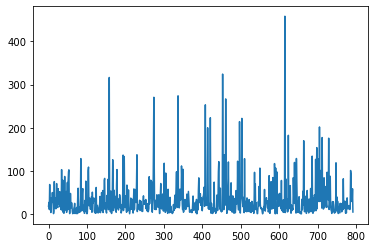

In [7]:
# Some data
path='/work/uo1075/u241292/output_mistral/alvise_bandpass/'
ds = xr.open_dataset(path+'E5pl00_1H_XXXX-XX_daily_250hPa_EKE_mergetime.nc')
myvar = ds['var131'][:,0,:,:].values
lat = ds['lat']
lon = ds['lon']
time = ds['time']
# ds.info()

pointCoords = [40, -37] # [lat, lon] one random point
idlat = np.where(abs(pointCoords[0]-lat)==min(abs(pointCoords[0]-lat)))[0]
idlon = np.where(abs(pointCoords[1]-lon)==min(abs(pointCoords[1]-lon)))[0]
ts = np.squeeze(myvar[:, idlat, idlon])

plt.plot(ts)
plt.show()

## Lanczos filters

In [16]:
ts_low30, ts_low30_noNans = lanczos(ts, cutoff=30, returnNonan=True)
ts_low10, ts_low10_noNans = lanczos(ts, cutoff=10, returnNonan=True)
# the high-pass filter here is just the origial time series minus the low-pass filtered one:
ts_hig30 = ts - ts_low30 + np.nanmean(ts_low30) 
# an idea to get periods only between 10 and 30 days: 10-day low-pass on 30-day high-pass filtered series
ts_hig30_noNans = ts[~np.isnan(ts_low30)] - ts_low30_noNans + np.nanmean(ts_low30_noNans)
ts_1030, ts_1030_noNans = lanczos(ts_hig30_noNans, cutoff=10, returnNonan=True)

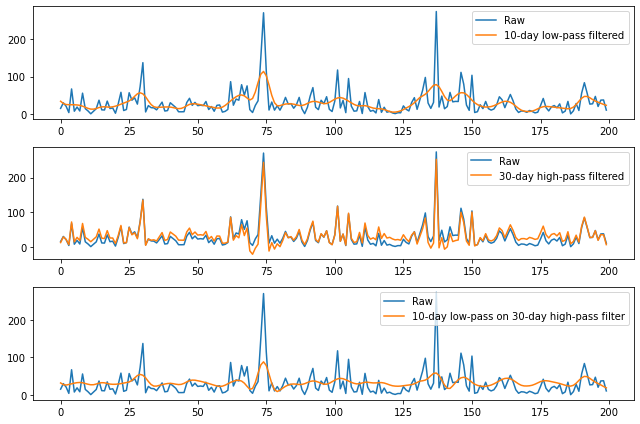

In [17]:
fig = plt.figure(figsize = (9,6))

ax = fig.add_subplot(311)
plt.plot(ts[200:400], label='Raw')
plt.plot(ts_low10[200:400], label='10-day low-pass filtered')
plt.legend()

ax = fig.add_subplot(312)
plt.plot(ts[200:400], label='Raw')
plt.plot(ts_hig30[200:400], label='30-day high-pass filtered')
plt.legend()

ax = fig.add_subplot(313)
plt.plot(ts[200:400], label='Raw')
plt.plot(ts_1030_noNans[180:380], label='10-day low-pass on 30-day high-pass filter')
plt.legend()

plt.tight_layout()
plt.show()

## Check if works

In [18]:
freq,   psd,   pctl,   max5,   meanRed   = periods(standardize(ts), dt=1, nsim=1000)
freq_f, psd_f, pctl_f, max5_f, meanRed_f = periods(standardize(ts_low10_noNans), dt=1, nsim=1000)
freq_g, psd_g, pctl_g, max5_g, meanRed_g = periods(standardize(ts_hig30_noNans), dt=1, nsim=1000)
freq_h, psd_h, pctl_h, max5_h, meanRed_h = periods(standardize(ts_1030_noNans), dt=1, nsim=1000)

/tmp/ipykernel_1074692/935646122.py:241: RuntimeWarning: divide by zero encountered in true_divide
  per=1/f


/tmp/ipykernel_1074692/2609860036.py:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/freq, psd,'b', label='Spectrum')
/tmp/ipykernel_1074692/2609860036.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/freq,runmean(pctl[:,2], window=31, fillaround=True), '--g', label='95th Pctl')
/tmp/ipykernel_1074692/2609860036.py:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/freq,runmean(pctl[:,3], window=31, fillaround=True), '-g',  label='99th Pctl')
/tmp/ipykernel_1074692/2609860036.py:16: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/freq_f, psd_f,'b', label='Spectrum')
/tmp/ipykernel_1074692/2609860036.py:17: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/freq_f,runmean(pctl_f[:,2], window=31, fillaround=True), '--g', label='95th Pctl')
/tmp/ipykernel_1074692/2609860036.py:18: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/freq_f,runmean(pctl_

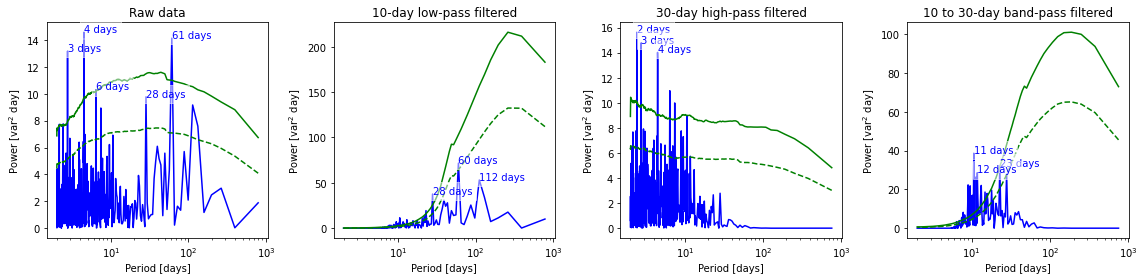

In [20]:
fig = plt.figure(figsize = (16,4))

ax = fig.add_subplot(141)
plt.plot(1/freq, psd,'b', label='Spectrum')
plt.plot(1/freq,runmean(pctl[:,2], window=31, fillaround=True), '--g', label='95th Pctl')
plt.plot(1/freq,runmean(pctl[:,3], window=31, fillaround=True), '-g',  label='99th Pctl')
plt.xlabel('Period [days]')
plt.ylabel('Power [var$^{2}$ day]')
plt.xscale('log')
plt.title('Raw data')
for i in range(5):
    t=plt.text(1/max5[i,0],max5[i,1],'%.0f days' %round(max5[i,2]), color='blue')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='w'))
    
ax = fig.add_subplot(142)
plt.plot(1/freq_f, psd_f,'b', label='Spectrum')
plt.plot(1/freq_f,runmean(pctl_f[:,2], window=31, fillaround=True), '--g', label='95th Pctl')
plt.plot(1/freq_f,runmean(pctl_f[:,3], window=31, fillaround=True), '-g',  label='99th Pctl')
plt.xlabel('Period [days]')
plt.ylabel('Power [var$^{2}$ day]')
plt.title('10-day low-pass filtered')
for i in range(3):
    t=plt.text(1/max5_f[i,0],max5_f[i,1],'%.0f days' %round(max5_f[i,2]), color='blue')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='w'))
plt.xscale('log')

ax = fig.add_subplot(143)
plt.plot(1/freq_g, psd_g,'b', label='Spectrum')
plt.plot(1/freq_g,runmean(pctl_g[:,2], window=31, fillaround=True), '--g', label='95th Pctl')
plt.plot(1/freq_g,runmean(pctl_g[:,3], window=31, fillaround=True), '-g',  label='99th Pctl')
plt.xlabel('Period [days]')
plt.ylabel('Power [var$^{2}$ day]')
plt.title('30-day high-pass filtered')
for i in range(3):
    t=plt.text(1/max5_g[i,0],max5_g[i,1],'%.0f days' %round(max5_g[i,2]), color='blue')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='w'))
plt.xscale('log')

ax = fig.add_subplot(144)
plt.plot(1/freq_h, psd_h,'b', label='Spectrum')
plt.plot(1/freq_h,runmean(pctl_h[:,2], window=31, fillaround=True), '--g', label='95th Pctl')
plt.plot(1/freq_h,runmean(pctl_h[:,3], window=31, fillaround=True), '-g',  label='99th Pctl')

plt.xlabel('Period [days]')
plt.ylabel('Power [var$^{2}$ day]')
plt.title('10 to 30-day band-pass filtered')
for i in range(3):
    t=plt.text(1/max5_h[i,0],max5_h[i,1],'%.0f days' %round(max5_h[i,2]), color='blue')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='w'))
plt.xscale('log')

plt.tight_layout()
plt.show()